In [1]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")
import models.utils as utils
import csv

from torchvision import transforms, models
import evals.embed_evals as evals
import pickle
import plot_data as plot
import shutil
from os import listdir
from os.path import isfile, join
import SimpleITK as sitk
import sys
sys.path.insert(0, 'code/data_gen')
import gen_triplets
import pandas as pd
from omegaconf import OmegaConf as oc

In [86]:
base_config = oc.load("/net/scratch/tianh/explain_teach/models/configs/base.yaml")
dataset_config = oc.load("/net/scratch/tianh/explain_teach/models/configs/wv_3d/dataset.yaml")
model_config = oc.load("/net/scratch/tianh/explain_teach/models/configs/wv_3d/model.yaml")

In [88]:
for i in np.arange(0,1.1,0.1):
    triplet = os.path.join("/net/scratch/tianh/explain_teach/models/configs/wv_3d/" ,f"align={str(np.around(i,1))}.yaml")
    triplet_config = oc.load(triplet)
    configs = oc.merge(base_config, dataset_config,  model_config, triplet_config)
    oc.save(config=configs, f=triplet)
    # print(configs)
    break

In [61]:
df = pd.read_csv("/net/scratch/tianh-shared/wv-3d/data.csv")
selected_features = ["head size","body size","tail size", "texture"]
df[selected_features]

,head size,body size,tail size,texture
0,1.637854,1.078957,0.313675,-0.313675
1,-1.659968,-0.824899,-0.543817,0.543817
2,-1.856387,1.950230,1.379527,-1.379527
3,1.554202,0.886635,-0.603218,0.603218
4,1.681563,0.794190,1.105545,-1.105545
...,...,...,...,...
315,-0.356652,0.554175,0.599029,-0.599029
316,-0.509185,0.370120,-0.135512,0.135512
317,0.968567,1.615310,-0.492433,0.492433
318,0.557385,0.679140,1.027593,-1.027593


In [62]:
dataset = torchvision.datasets.ImageFolder("/net/scratch/tianh-shared/wv-3d/pseudo_label/auto_split/train")
syn_y_train = [x[1] for x in dataset]
dataset = torchvision.datasets.ImageFolder("/net/scratch/tianh-shared/wv-3d/pseudo_label/auto_split/test")
syn_y_test = [x[1] for x in dataset]

In [65]:
train_embeds = pickle.load(open("/net/scratch/tianh-shared/wv-3d/pseudo_label/auto_split/train.pkl", "rb"))
valid_embeds = pickle.load(open("/net/scratch/tianh-shared/wv-3d/pseudo_label/auto_split/valid.pkl", "rb"))
test_embeds = pickle.load(open("/net/scratch/tianh-shared/wv-3d/pseudo_label/auto_split/test.pkl", "rb"))

In [70]:
powers=2
scores = []
weights = []
for w1 in np.arange(-10000, 10, 10):
    for w2 in np.arange(-10000, 10, 10):
        for w3 in np.arange(-10000, 10, 10):
            for w4 in np.arange(-10000, 10, 10):
                w = [w1,w2,w3,w4]
                weights.append(w)
                scores.append(evals.distorted_1nn(train_embeds, syn_y_train, test_embeds, syn_y_test, w, powers))

KeyboardInterrupt: 

In [ ]:
scores

0.525

In [32]:
weights = [2.7303, 1]
for total in [10000, 25000, 50000, 100000]:
    train = gen_triplets.sample_triplets(np.arange(120), int(total*0.8), weights, train_embeds)
    pickle.dump(train, open(f"/net/scratch/tianh/explain_teach/data/wv_triplets/align=1/train_triplets_{str(total)}.pkl", "wb"))
    valid = gen_triplets.sample_mixed_triplets(np.arange(40),np.arange(120), int(total*0.2), weights, valid_embeds, train_embeds)
    pickle.dump(valid, open(f"/net/scratch/tianh/explain_teach/data/wv_triplets/align=1/valid_triplets_{str(total)}.pkl", "wb"))

total triplets number:  842520
total triplets number:  285600
total triplets number:  842520
total triplets number:  285600
total triplets number:  842520
total triplets number:  285600
total triplets number:  842520
total triplets number:  285600


In [104]:
weights = [10000, 1]
for total in [10000, 25000, 50000, 100000]:
    train = gen_triplets.sample_triplets(np.arange(120), int(total*0.8), weights, train_embeds)
    pickle.dump(train, open(f"/net/scratch/tianh/explain_teach/data/wv_triplets/w1=10000_w2=1/train_triplets_{str(total)}.pkl", "wb"))
    valid = gen_triplets.sample_mixed_triplets(np.arange(40),np.arange(120), int(total*0.2), weights, valid_embeds, train_embeds)
    pickle.dump(valid, open(f"/net/scratch/tianh/explain_teach/data/wv_triplets/w1=10000_w2=1/valid_triplets_{str(total)}.pkl", "wb"))

total triplets number:  842520
total triplets number:  285600
total triplets number:  842520
total triplets number:  285600
total triplets number:  842520
total triplets number:  285600
total triplets number:  842520
total triplets number:  285600


In [105]:

test = gen_triplets.sample_mixed_triplets(np.arange(40),np.arange(120), 10000, weights, test_embeds, train_embeds)
pickle.dump(test, open(f"/net/scratch/tianh/explain_teach/data/wv_triplets/w1=10000_w2=1/test_triplets_10k.pkl", "wb"))

total triplets number:  285600


In [6]:
valid = pickle.load(open("/net/scratch/tianh/explain_teach/data/wv_triplets/align=1/valid_triplets_12000.pkl", "rb"))
valid

[[30, 86, 27],
 [4, 23, 10],
 [36, 96, 61],
 [38, 73, 67],
 [13, 86, 39],
 [27, 49, 29],
 [26, 86, 30],
 [19, 58, 18],
 [21, 95, 57],
 [33, 9, 54],
 [13, 53, 26],
 [16, 6, 85],
 [34, 118, 0],
 [9, 25, 99],
 [29, 94, 82],
 [29, 34, 15],
 [27, 117, 37],
 [0, 77, 81],
 [33, 115, 20],
 [22, 95, 6],
 [14, 88, 83],
 [9, 28, 52],
 [39, 45, 107],
 [7, 71, 52],
 [13, 81, 26],
 [25, 90, 30],
 [35, 30, 38],
 [22, 52, 100],
 [29, 88, 91],
 [39, 73, 62],
 [3, 46, 55],
 [39, 91, 60],
 [10, 76, 12],
 [21, 94, 101],
 [36, 66, 49],
 [2, 59, 114],
 [5, 4, 48],
 [23, 109, 9],
 [32, 103, 49],
 [5, 76, 112],
 [31, 38, 29],
 [9, 95, 90],
 [21, 112, 105],
 [31, 34, 35],
 [31, 19, 7],
 [8, 46, 118],
 [28, 77, 0],
 [4, 67, 61],
 [29, 94, 18],
 [26, 78, 17],
 [6, 115, 27],
 [7, 16, 23],
 [16, 52, 93],
 [18, 21, 76],
 [17, 36, 113],
 [33, 93, 29],
 [33, 113, 57],
 [3, 2, 113],
 [11, 73, 5],
 [4, 20, 77],
 [25, 0, 2],
 [1, 22, 82],
 [6, 46, 43],
 [29, 54, 82],
 [28, 27, 43],
 [4, 97, 116],
 [23, 60, 36],
 [18, 59

In [ ]:
triplets = pickle.load(open("/net/scratch/tianh/explain_teach/data/bm_triplets/3c2_unique=182/train_triplets.pkl","rb"))
c1 = np.arange(80)
c2 = np.arange(80,160)
total = 0
correct = 0
for t in triplets:
    a, p, n = t[0], t[1], t[2]
    if a in c1 and p in c1 and n in c1: continue
    elif a in c2 and p in c2 and n in c2: continue

    if a in c1:
        if p in c1 and n in c2: correct += 1
    if a in c2:
        if p in c2 and n in c1: correct += 1

    total += 1
correct/total

0.5482456140350878

In [ ]:
triplets = pickle.load(open("/net/scratch/tianh/explain_teach/data/bm_triplets/3c2_unique=182/valid_triplets.pkl","rb"))
c1 = np.arange(20)
c2 = np.arange(20,40)
total = 0
correct = 0
for t in triplets:
    a, p, n = t[0], t[1], t[2]
    if a in c1 and p in c1 and n in c1: continue
    elif a in c2 and p in c2 and n in c2: continue

    if a in c1:
        if p in c1 and n in c2: correct += 1
    if a in c2:
        if p in c2 and n in c1: correct += 1

    total += 1
correct/total

0.5344827586206896

## cross validation

In [ ]:
c1, c2, c3, c4 = np.arange(1583), np.arange(1583,3166), np.arange(600,900), np.arange(900,1200)
splits = utils.cross_val_multiclass([c1,c2], 10)

In [ ]:
c1 = np.arange(1583)
valid_test = np.random.choice(c1, 300,replace=False)
c1_valid = np.random.choice(valid_test, 150, replace=False)
c1_test = np.setdiff1d(valid_test, c1_valid)
c1_train = np.setdiff1d(c1, valid_test)

In [ ]:
c2 = np.arange(1583,5856)
valid_test = np.random.choice(c2, 300,replace=False)
c2_valid = np.random.choice(valid_test, 150, replace=False)
c2_test = np.setdiff1d(valid_test, c2_valid)
c2_train = np.setdiff1d(c2, valid_test)

In [ ]:
pickle.dump(splits,open("models/pneumonia_splits_imb.pkl","wb"))

In [ ]:
src_dir = "/net/scratch/tianh-shared/warblers/inat/4class"
dst_dir = "/net/scratch/tianh-shared/warblers/data"
split5 = pickle.load(open("models/bird_splits.pkl","rb"))[5]

In [ ]:
train, val, test = split5
instances = utils.dataset_filenames(src_dir)

In [ ]:
labels = [v[1] for v in instances[train]]
unique = set(labels)
counts = [labels.count(c) for c in unique]
counts

[240, 240, 240, 240]

In [ ]:
lambdas = np.arange(0.1, 1, 0.1)
clf = [0.875, 0.925, 0.95, 0.975, 0.975, 0.975, 1, 1, 0.975]
triplet = [0.897,0.913,0.913,0.855,0.841,0.826,0.841,0.841,0.841]

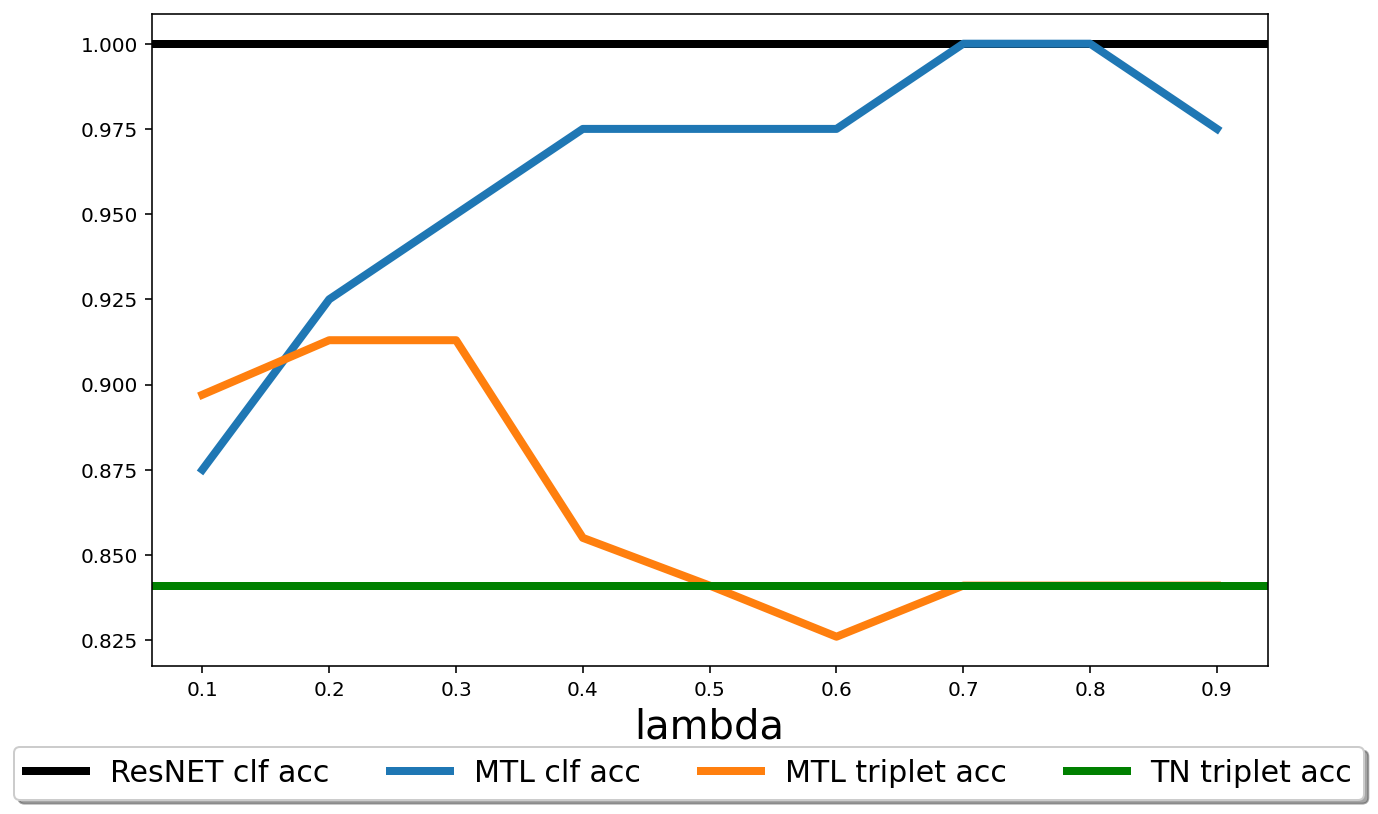

In [ ]:
lw=4
plt.rc('legend', fontsize=15)
plt.figure(figsize=(10,6))
plt.axhline(1, c='black',linewidth=lw, label="ResNET clf acc")
plt.plot(lambdas, clf,linewidth=lw, label="MTL clf acc")
plt.plot(lambdas, triplet,linewidth=lw, label="MTL triplet acc")
plt.axhline(0.841, c='green',linewidth=lw, label="TN triplet acc")
plt.xlabel('lambda')
# plt.title("MTL trained on human triplets")
plt.legend(loc='upper right', bbox_to_anchor=(1.1, -0.1),fancybox=True, shadow=True, ncol=4)
plt.savefig("figs/MTL_lambdas.pdf", format="pdf", bbox_inches="tight")

In [ ]:

triplets = pickle.load(open("/net/scratch/tianh/triplet-webapp/backup/trial0/butterfly.triplets.pkl","rb"))

In [ ]:
train_idx = pickle.load(open("data/bm_train_idx.pkl", "rb"))[1]
val_idx  = pickle.load(open("data/bm_valid_idx.pkl", "rb"))[1]

In [ ]:
train_triplets = []
val_triplets = []
for triplet in triplets:
    a,p,n = triplet
    if a in train_idx.keys() and p in train_idx.keys() and n in train_idx.keys():
        new = [train_idx[a], train_idx[p], train_idx[n]]
        train_triplets.append(new)
    elif a in val_idx.keys() and p in val_idx.keys() and n in val_idx.keys():
        new = [val_idx[a], val_idx[p], val_idx[n]]
        val_triplets.append(new)

In [ ]:

train_triplets = "/net/scratch/tianh/explain_teach/data/bm_triplets/3c2_unique=182/train_triplets.pkl"
valid_triplets = "/net/scratch/tianh/explain_teach/data/bm_triplets/3c2_unique=182/valid_triplets.pkl"
train_triplets = pickle.load(open(train_triplets, "rb"))
valid_triplets = pickle.load(open(valid_triplets, "rb"))

In [ ]:

train_lpips_distance = "/net/scratch/tianh/explain_teach/embeds/lpips/lpips.bm.train.pkl"
valid_lpips_distance = "/net/scratch/tianh/explain_teach/embeds/lpips/lpips.bm.valid.pkl"
train_lpips_distance = pickle.load(open(train_lpips_distance, "rb"))
valid_lpips_distance = pickle.load(open(valid_lpips_distance, "rb"))

In [ ]:
correct = 0
total = 0
for htriplet in train_triplets:
    total += 1
    a,p,n = htriplet[0], htriplet[1], htriplet[2]
    if train_lpips_distance[a, p] < train_lpips_distance[a, n]:
        correct += 1
correct/total


0.5769230769230769

In [ ]:
correct = 0
total = 0
for htriplet in valid_triplets:
    total += 1
    a,p,n = htriplet[0], htriplet[1], htriplet[2]
    if valid_lpips_distance[a, p] < valid_lpips_distance[a, n]:
        correct += 1
correct/total


0.5507246376811594

In [ ]:
# train_pairwise_distance= "embeds/lpips.bm.train.pkl" 
# valid_pairwise_distance= "embeds/lpips.bm.valid.pkl" 
# train_pairwise_distance = pickle.load(open(train_pairwise_distance, "rb"))
# valid_pairwise_distance = pickle.load(open(valid_pairwise_distance, "rb"))

train_triplets = "/net/scratch/tianh/explain_teach/data/bm_triplets/train_triplets.pkl"
valid_triplets = "/net/scratch/tianh/explain_teach/data/bm_triplets/valid_triplets.pkl"
train_triplets = pickle.load(open(train_triplets, "rb"))
valid_triplets = pickle.load(open(valid_triplets, "rb"))

In [ ]:
train = pickle.load(open("embeds/TN_bm_train.pkl","rb"))
valid = pickle.load(open("embeds/TN_bm_valid.pkl","rb"))
triplets = pickle.load(open("data/bm_triplets/val2train_triplets.pkl","rb"))

In [ ]:
acc = evals.val2train_triplet_acc(train, valid, triplets)
acc

100%|██████████| 508800/508800 [00:21<00:00, 23501.76it/s]


0.8758490566037735

In [ ]:
acc = evals.triplet_acc(train, train_triplets)
acc

100%|██████████| 669920/669920 [00:29<00:00, 22594.10it/s]


0.8902451038930022

In [ ]:
acc = evals.triplet_acc(valid, valid_triplets)
acc

100%|██████████| 9880/9880 [00:00<00:00, 23948.86it/s]


0.8486842105263158

In [ ]:

train_triplets = "/net/scratch/tianh/bm/triplets/train_triplets.pkl"
valid_triplets = "/net/scratch/tianh/bm/triplets/valid_triplets.pkl"
# clf_train_triplets = "/net/scratch/tianh/bm/triplets/clf_train_triplets.pkl"
# clf_valid_triplets = "/net/scratch/tianh/bm/triplets/clf_valid_triplets.pkl"

train_triplets = pickle.load(open(train_triplets, "rb"))

In [ ]:

train_dir = "/net/scratch/hanliu-shared/data/bm/train"
valid_dir = "/net/scratch/hanliu-shared/data/bm/valid"
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=utils.bm_transform())
valid_dataset = torchvision.datasets.ImageFolder(valid_dir, transform=utils.bm_transform())
train_inputs = torch.tensor(np.array([data[0].numpy() for data in train_dataset]))
valid_inputs = torch.tensor(np.array([data[0].numpy() for data in valid_dataset]))
train_labels = torch.tensor(np.array([data[1] for data in train_dataset]))
valid_labels = torch.tensor(np.array([data[1] for data in valid_dataset]))

In [ ]:
np.where(train_labels==0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),)

In [ ]:
a = pickle.load(open("/net/scratch/tianh/bm/triplets/clf_train_triplets.pkl","rb"))

In [ ]:
idx = np.random.choice(len(combs), 32, replace=False)
sample = combs[idx]
len(np.unique(sample.flatten()))

65

In [ ]:
import torch
a = torch.tensor(sample)

In [ ]:
torch.unique(torch.flatten(a))

tensor([  7,   9,  10,  11,  12,  13,  14,  15,  18,  19,  21,  22,  29,  32,
         33,  34,  36,  38,  39,  40,  41,  42,  46,  55,  56,  57,  58,  61,
         63,  70,  72,  76,  82,  84,  86,  88,  90,  92,  93,  98,  99, 103,
        106, 108, 110, 111, 112, 113, 114, 115, 116, 117, 122, 129, 131, 132,
        133, 141, 142, 144, 145, 149, 151, 153, 155])

In [ ]:
triplet_idx = []
for c in combs:
    x1, x2, x3 = c[0], c[1], c[2]
    if train_pairwise_distance[x1, x2] > train_pairwise_distance[x1, x3]:
        triplet_idx.append([x1, x3, x2])
    else:
        triplet_idx.append([x1, x2, x3])

In [ ]:
pickle.dump(np.array(triplet_idx), open('/net/scratch/tianh/bm/triplets/train_triplets.pkl',"wb"))

In [ ]:
a = pickle.load(open('/net/scratch/tianh/bm/triplets/train_triplets.pkl',"rb"))
a.shape

(669920, 3)

In [ ]:
np.array(triplet_idx).shape

(669881, 3)

In [ ]:
food100 = []
with open('/net/scratch/tianh/food100-dataset/all-triplets.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        food100.append(row)

190376

In [ ]:

transform = transforms.Compose([
    transforms.Resize([230,230]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_dir = '/net/scratch/tianh/food100-dataset/images'
dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform)
total_idx = np.arange(len(dataset))

In [ ]:
train_img_idx = np.random.choice(total_idx, int(len(total_idx)*0.615), replace=False)
valid_img_idx = np.setdiff1d(total_idx, train_img_idx)

train_data = torch.tensor(np.array([dataset[i][0].numpy() for i in train_img_idx]))
valid_data = torch.tensor(np.array([dataset[i][0].numpy() for i in valid_img_idx]))
train_label = torch.tensor(np.array([dataset[i][1] for i in train_img_idx]))
valid_label = torch.tensor(np.array([dataset[i][1] for i in valid_img_idx]))

valid_triplets = []
for t in triplets:
    if t[0] in valid_label and t[1] in valid_label and t[2] in valid_label:
        valid_triplets.append(t)
train_triplets = []
for t in triplets:
    if t[0] in train_label and t[1] in train_label and t[2] in train_label:
        train_triplets.append(t)
len(train_triplets), len(valid_triplets)

(41685, 11018)

In [ ]:
41685/11018

3.783354510800508

In [ ]:
len(triplets)*0.2

38075.200000000004

In [ ]:
triplets = pickle.load(open("/net/scratch/tianh/food100-dataset/triplets_idx.pkl", "rb"))

In [ ]:
train_triplets

151051

In [ ]:
total_idx = np.arange(100)
train_idx = np.random.choice(total_idx, len(total_idx)*8//10, replace=False)
valid_idx = np.setdiff1d(total_idx, train_idx)
train_triplets = 0
valid_triplets = 0
for t in triplets:
    if t[0] in train_idx:
        train_triplets += 1
    else:
        valid_triplets += 1
train_triplets/len(triplets), valid_triplets/len(triplets)

(0.7934350968609488, 0.20656490313905115)

In [ ]:
path = "/net/scratch/tianh/food100-dataset/images"
dir_list = os.listdir(path)
dir_list

In [ ]:
import shutil
for image in dir_list:
    image_dir = os.path.join(path, image[:-4]) 
    if not os.path.exists(image_dir):
        os.mkdir(image_dir) 
        shutil.copy(os.path.join(path,image),image_dir)

### evaluating lpips(bm) by class

In [ ]:
scores = []
for i in range(80):
    correct = 0
    total = 0
    for j in range(80):
        for k in range(80,160):
            total += 1
            if train_dist[i,j] <= train_dist[i,k]:
                correct += 1
    scores.append(correct/total)
    
for i in range(80, 160):
    correct = 0
    total = 0
    for j in range(80):
        for k in range(80,160):
            total += 1
            if train_dist[i,j] >=  train_dist[i,k]:
                correct += 1
    scores.append(correct/total)
sum(scores)/len(scores)

0.5788437500000001

## evaluating lpips(food) w/ triplets

In [ ]:
distances_matrix = pickle.load(open("lpips.food.pkl", "rb"))
triplets = pickle.load(open("/net/scratch/tianh/food100-dataset/triplets_idx.pkl", "rb"))

In [ ]:
total = len(triplets)
correct = 0
for triplet in triplets:
    if distances_matrix[triplet[0], triplet[1]] <= distances_matrix[triplet[0], triplet[2]]:
        correct += 1
correct/total

0.5610423582804556

## triplet generalization error

In [ ]:
import os, pickle
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances 
import torch
import torchvision
from tqdm import tqdm
pdist = torch.nn.PairwiseDistance()
%matplotlib inline
%config InlineBackend.figure_format='retina'

np.random.seed(42)
# def euc_dist(x, y): return euclidean_distances([x],[y])[0][0]
def euc_dist(x, y): return np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))

In [ ]:
def a(f):
    return f(3)
def f(x): return x+1
a(f)

4

In [ ]:
import tste
triplets = "/net/scratch/tianh/bm/triplets/train_triplets.pkl"
triplets = np.array(pickle.load(open(triplets, "rb")))
embedding = tste.tste(triplets, no_dims=2, verbose=False, max_iter=1000)

In [ ]:
train_align = []
for triplet in tqdm(triplets):
    a, p, n = triplet
    ap = euc_dist(embedding[a], embedding[p]) 
    an = euc_dist(embedding[a], embedding[n])
    train_align.append(ap < an)
print(np.mean(train_align))

100%|██████████| 669920/669920 [00:10<00:00, 64893.71it/s]


0.8420945784571292


In [ ]:
triplets = np.array(pickle.load(open("/net/scratch/tianh/food100-dataset/triplets_idx.pkl", "rb")))
valid_path = "model/embeds/triplet_net_food_triplet.pkl"
X_train = pickle.load(open(valid_path, "rb"))


In [ ]:
train_align = []
for triplet in tqdm(triplets):
    a, p, n = triplet
    ap = euc_dist(X_train[a], X_train[p]) 
    an = euc_dist(X_train[a], X_train[n])
    train_align.append(ap < an)
print(np.mean(train_align))

0.8240271883010464


In [ ]:
X_train.shape

(160, 1000)

In [ ]:
model = 'triplet_net_food'
name = 'no_linear'
train_path = "/net/scratch/hanliu-shared/data/bm/embs/dwac_train_emb10.merged2.pkl"
valid_path = "/net/scratch/hanliu-shared/data/bm/embs/dwac_valid_emb10.merged2.pkl"
# train_path = '{}/{}_train_{}.pkl'.format("embeds", model, name)
# valid_path = '{}/{}_valid_{}.pkl'.format("embeds", model, name)
X_train = pickle.load(open(train_path, "rb"))
X_train = X_train[3]
X_valid = pickle.load(open(valid_path, "rb"))
X_valid=X_valid[3]
# valid_path = 'model/xd.pkl'
# X_train = pickle.load(open(valid_path, "rb"))

In [ ]:
train_align = []
train_dist = pickle.load(open("embeds/lpips.bm.train.pkl", "rb"))
# train_dist = train_dist[np.array(subset_idx)]
combs = torch.combinations(torch.arange(0, len(train_dist)).int(), r=3)
for c in tqdm(combs):
    a, p, n = c
# for i in tqdm(range(10000)):
#     a, p, n = np.random.choice(len(X_train), 3, replace=False)
    ap = train_dist[a, p] < train_dist[a, n]
    rd = euc_dist(X_train[a], X_train[p]) < euc_dist(X_train[a], X_train[n])
    train_align.append(ap == rd)
print(np.mean(train_align))

100%|██████████| 669920/669920 [00:35<00:00, 18745.99it/s]

0.5198008717458801


In [ ]:
valid_align = []
valid_dist = pickle.load(open("embeds/lpips.bm.valid.pkl", "rb"))
combs = torch.combinations(torch.arange(0, len(valid_dist)-1).int(), r=3)
for c in combs:
    a, p, n = c
    ap = valid_dist[a, p] < valid_dist[a, n]
    rd = euc_dist(X_valid[a], X_valid[p]) < euc_dist(X_valid[a], X_valid[n])
    valid_align.append(ap == rd)
print(np.mean(valid_align))

0.5894517999781158


In [ ]:
d_ap = pdist(torch.tensor(X_valid[combs[:,0]]), torch.tensor(X_valid[combs[:,1]]))
d_an = pdist(torch.tensor(X_valid[combs[:,0]]), torch.tensor(X_valid[combs[:,2]]))

In [ ]:
(d_ap < d_an).float().mean()

tensor(0.5828)

## human-compatible example selection

In [ ]:
model, name = 'dwac', 'emb10.merged2'
title = "prostatex"

train_path = 'embeds/{}_train_{}.pkl'.format(model, name)
f_train_dwac, y_train_dwac, x_train_dwac = pickle.load(open(train_path, "rb"))

In [ ]:
_, pdash_examples, _ = pdash(x_train_dwac,x_train_dwac,10,kernelType="Gaussian")
pdash_examples

array([182, 235, 159, 124, 214, 177, 228, 166,  74, 231])

dwac-lpips

In [ ]:
lpips = pickle.load(open("embeds/lpips.prostatex.train+valid.pkl","rb"))
lpips.shape

(319, 319)

In [ ]:
_, examples, _ = pdash_human.pdash(x_train_dwac,x_train_dwac, 10,lpips,kernelType="Gaussian")
examples

array([182, 235, 159, 124, 214, 177, 228, 166,  74,  39])

In [ ]:
_, examples, _ = pdash_human.pdash(x_train_dwac,x_train_dwac, 10,lpips, f_h_scale=0.1, kernelType="Gaussian")
examples

array([182, 168, 186, 201,  29, 237, 105,  86, 145, 177])

In [ ]:
_, examples, _ = pdash_human.pdash(x_train_dwac,x_train_dwac, 10,lpips, f_h_scale=1, kernelType="Gaussian")
examples

array([182, 168, 186, 201,  29, 237, 105,  86, 145, 177])

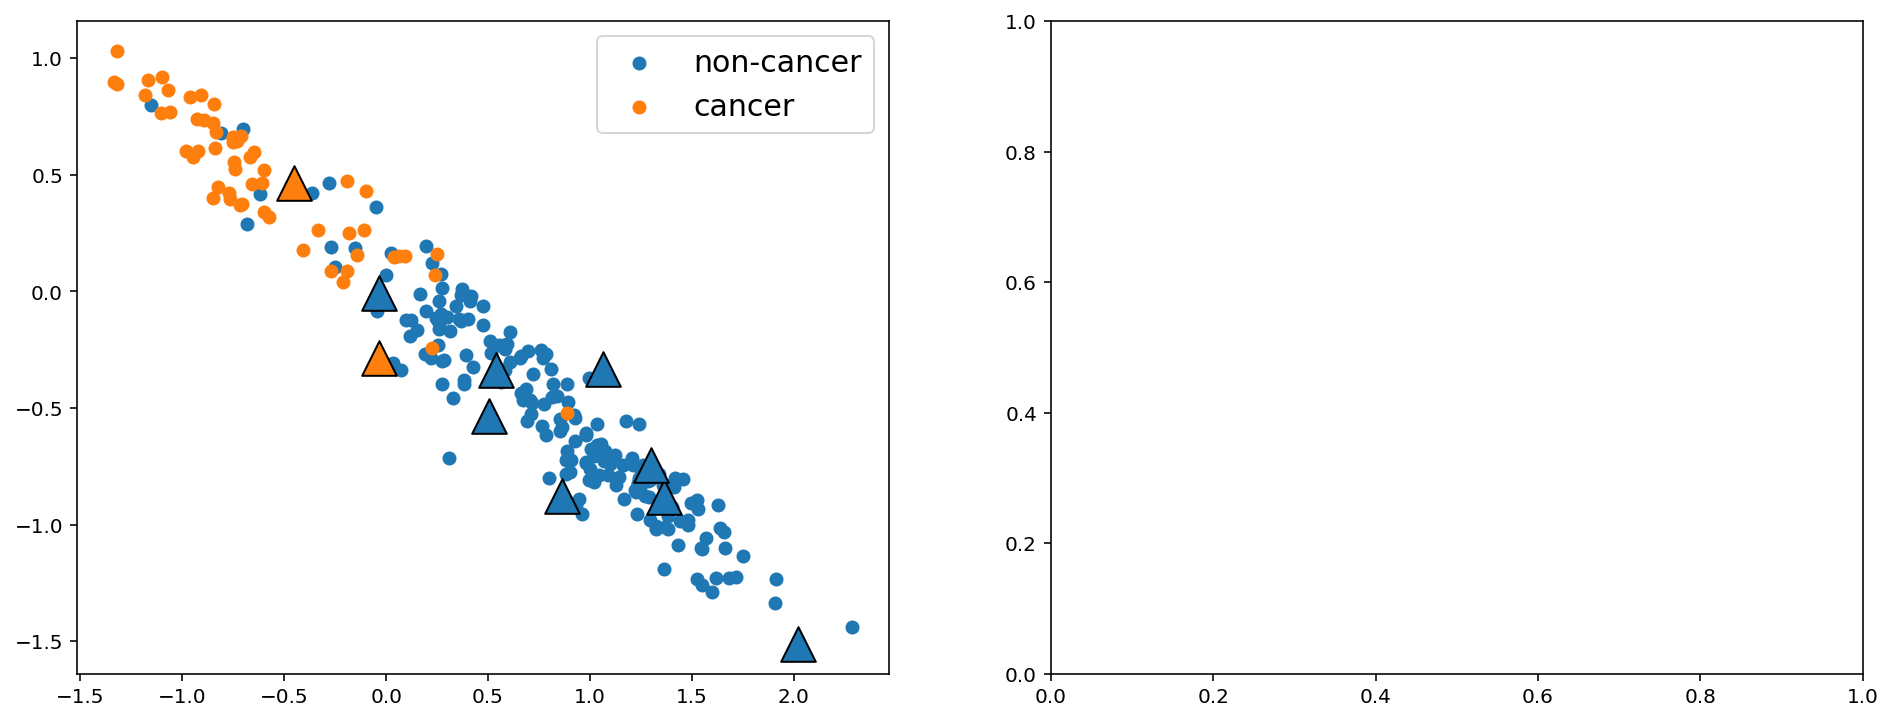

In [ ]:
utils.vis_proto(x_train_dwac, y_train_dwac, examples, "")

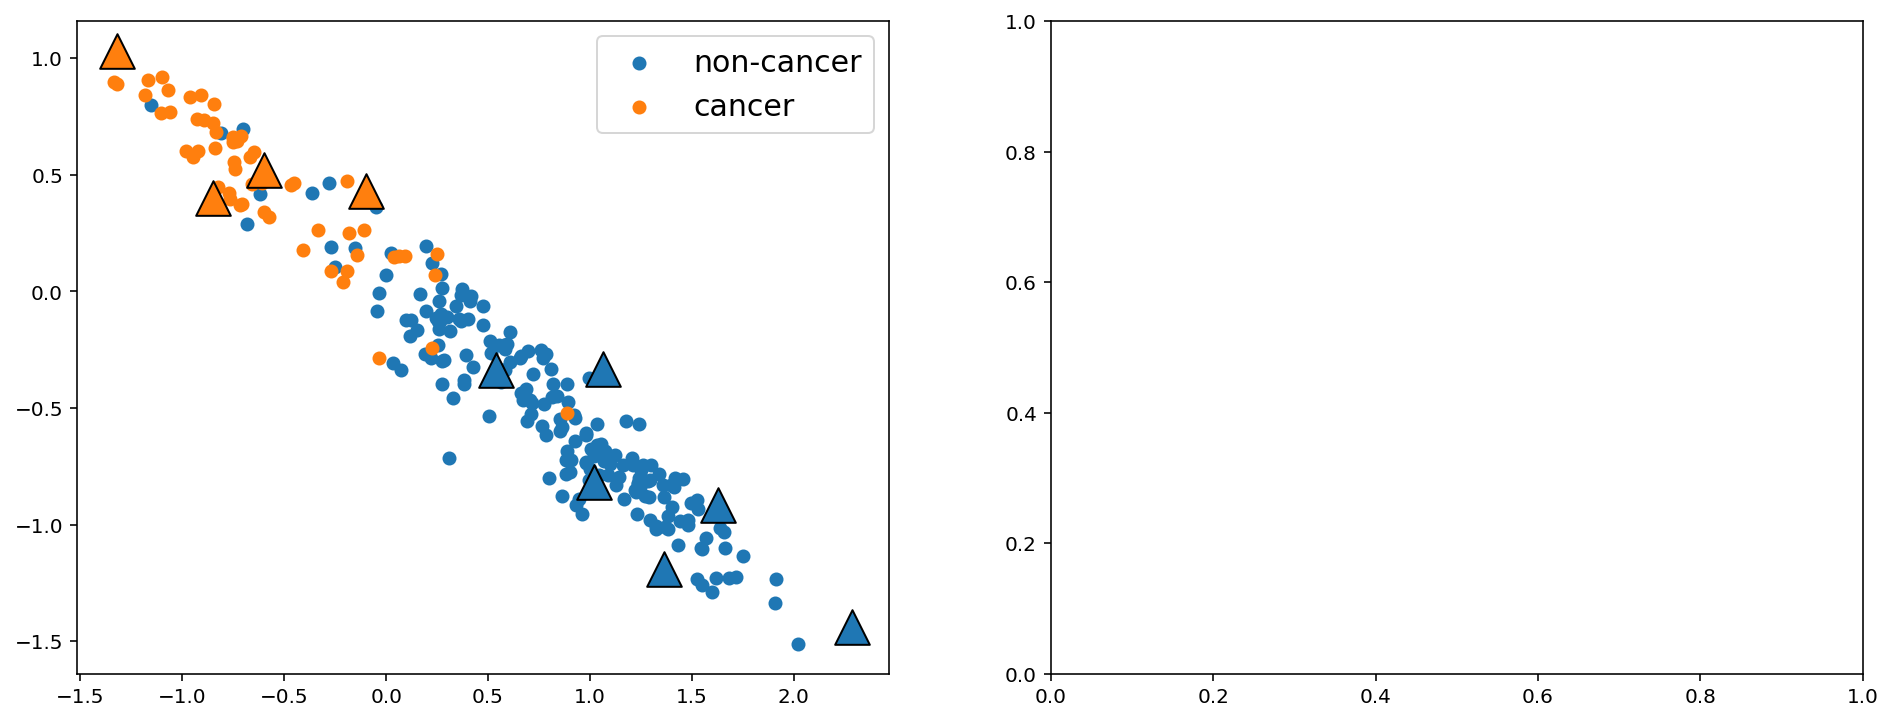

In [ ]:
utils.vis_proto(x_train_dwac, y_train_dwac, pdash_examples, "")

In [ ]:
L = 0.5
Kernel = 'Gaussian'
Gamma = 0.5
k_range = [1, 3]
m_range = list(range(3, 11))

In [ ]:
dataset = 'prostatex'
model = 'dwac'
name = 'emb10.merged2'
train_path = 'embeds/{}_train_{}.pkl'.format(model, name)
valid_path = 'embeds/{}_valid_{}.pkl'.format(model, name)
f_train, y_train, X_train = pickle.load(open(train_path, "rb"))
f_valid, y_valid, X_valid = pickle.load(open(valid_path, "rb"))
data = X_train, y_train, X_valid, y_valid

In [ ]:
dwac_f_scores_knn, dwac_f_score_svm = utils.get_full_score(data, k_range)
dwac_r_means_knn, dwac_r_confs_knn, dwac_r_means_svm, dwac_r_confs_svm = utils.get_random_score(data, k_range, m_range)
dwac_p_scores_knn, dwac_p_scores_svm = utils.get_protodash_score(data, k_range, m_range)

In [ ]:
def get_pdash_score(data, k_range, m_range, f_h_scale):
    p_idss = {}
    X_train, y_train, X_valid, y_valid = data
    for m in m_range:
        if m not in p_idss:
            try:
                _, index, _ = pdash_human.pdash(X_train,X_train, m,lpips, f_h_scale=f_h_scale, kernelType="Gaussian")
            except AttributeError:
                index = [0] * m
                print("error for m={}".format(m))
            p_idss[m] = index
    p_scores_knn, p_scores_svm = [], []
    for k in k_range:
        for m in m_range:
            p_scores_knn.append(utils.get_knn_score(k, data, p_idss[m]))
            try:
                s = utils.get_svm_score(k, data, p_idss[m])
            except:
                s = 0
            p_scores_svm.append(s)
    p_scores_knn = np.array(p_scores_knn).reshape(len(k_range), len(m_range))
    p_scores_svm = np.array(p_scores_svm).reshape(len(k_range), len(m_range))
    return p_scores_knn, p_scores_svm

In [ ]:
pdash_scores_knn1,pdash_scores_svm = get_pdash_score(data, k_range, m_range, 1)
pdash_scores_knn01,pdash_scores_svm = get_pdash_score(data, k_range, m_range, 0.1)
pdash_scores_knn001,pdash_scores_svm = get_pdash_score(data, k_range, m_range, 0.01)
pdash_scores_knn0001,pdash_scores_svm = get_pdash_score(data, k_range, m_range, 0.001)
pdash_scores_knn00001,pdash_scores_svm = get_pdash_score(data, k_range, m_range, 0.00001)

Text(0.5, 0.98, 'prostatex, dwac.lpips, AUC, KNN weights uniform')

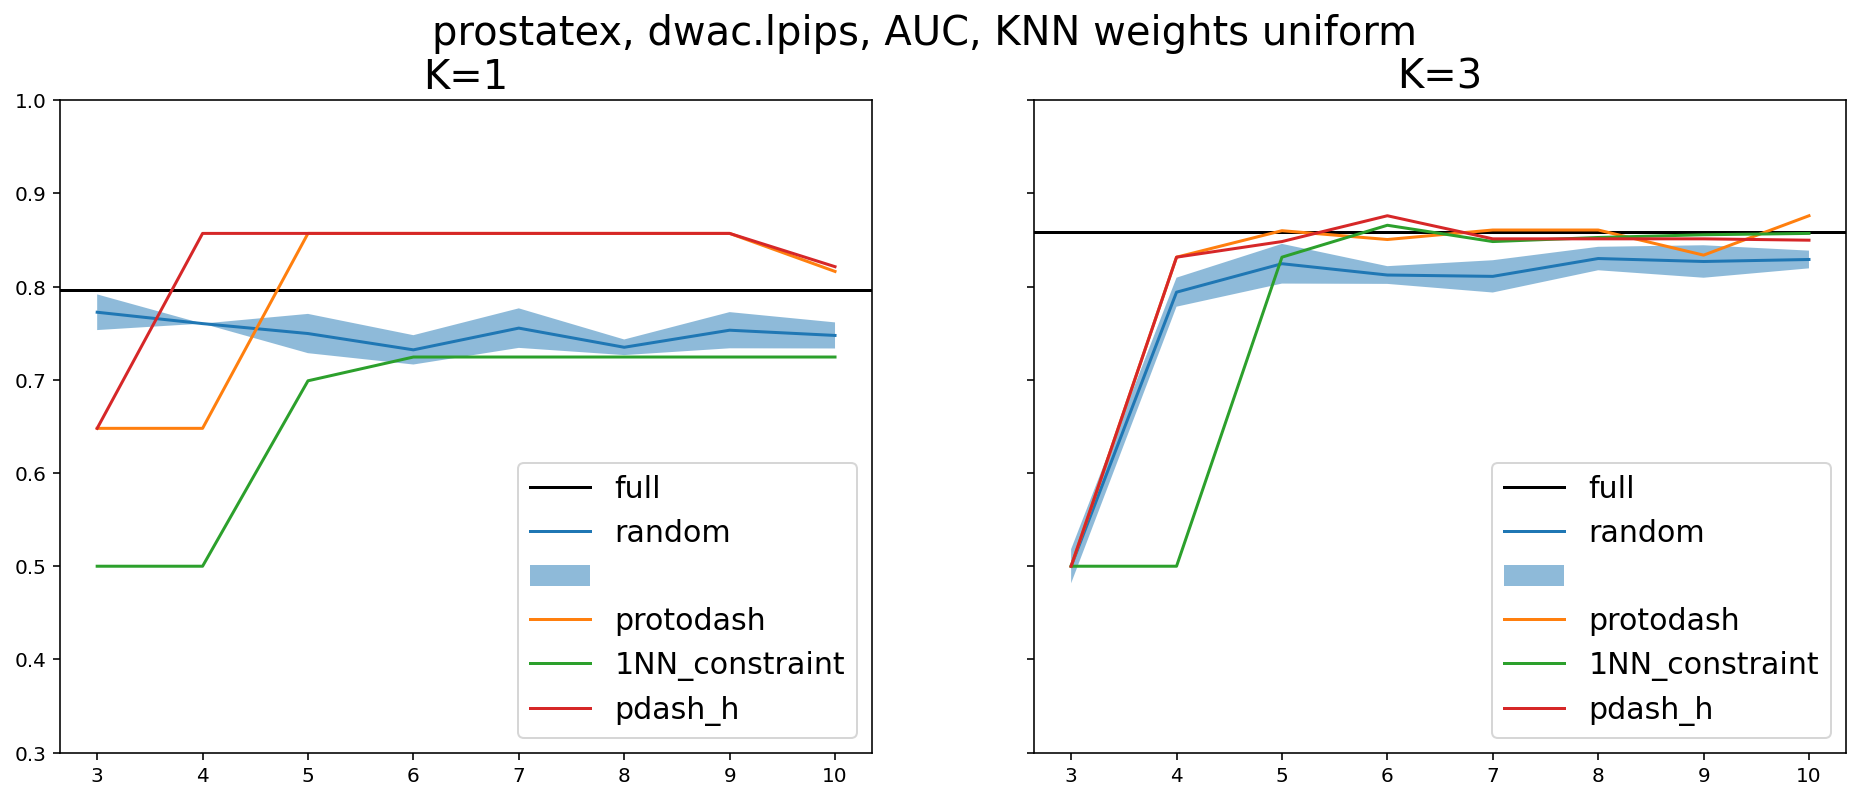

In [ ]:
fig, ax = plt.subplots(1, len(k_range), figsize=(16, 6), sharey=True)
for k in range(len(k_range)):
    ax[k].axhline(dwac_f_scores_knn[k], c='black')
    ax[k].plot(m_range, dwac_r_means_knn[k])
    ax[k].fill_between(m_range, dwac_r_means_knn[k] + dwac_r_confs_knn[k] / 2, dwac_r_means_knn[k] - dwac_r_confs_knn[k] / 2, alpha=0.5)
    ax[k].plot(m_range, dwac_p_scores_knn[k])
    # ax[k].plot(m_range, pdash_scores_knn1[k])
    ax[k].plot(m_range, pdash_scores_knn01[k])
    ax[k].plot(m_range, pdash_scores_knn001[k])
    # ax[k].plot(m_range, pdash_scores_knn0001[k])
    # ax[k].plot(m_range, pdash_scores_knn00001[k])
    ax[k].set_ylim(0.3, 1)
    ax[k].set_xticks(m_range)
    ax[k].set_title('K={}'.format(k_range[k]))
    ax[k].legend(['full', 'random', '', 'protodash', '1NN_constraint', 'pdash_h','0.0001'])
fig.suptitle('{}, {}.{}, AUC, KNN weights '.format(dataset, model, "lpips") + "uniform")

## generate triplets from LPIPS distance matrices
triplets.shape := [k, 3]

triplets[i] = [anchor, positive, negative]

In [ ]:
distance_matrix = pickle.load(open("lpips.prostatex.train+valid.pkl", "rb"))
distance_matrix.shape

(319, 319)

In [ ]:
triplets_fname = "data/triplets.px.train+valid.pkl"
tste_fname = "data/tste.px.train+valid.pkl"

In [ ]:
# embeds = utils.get_tste(distance_matrix, triplets_fname, tste_fname, max_iter=100)

(256, 2)

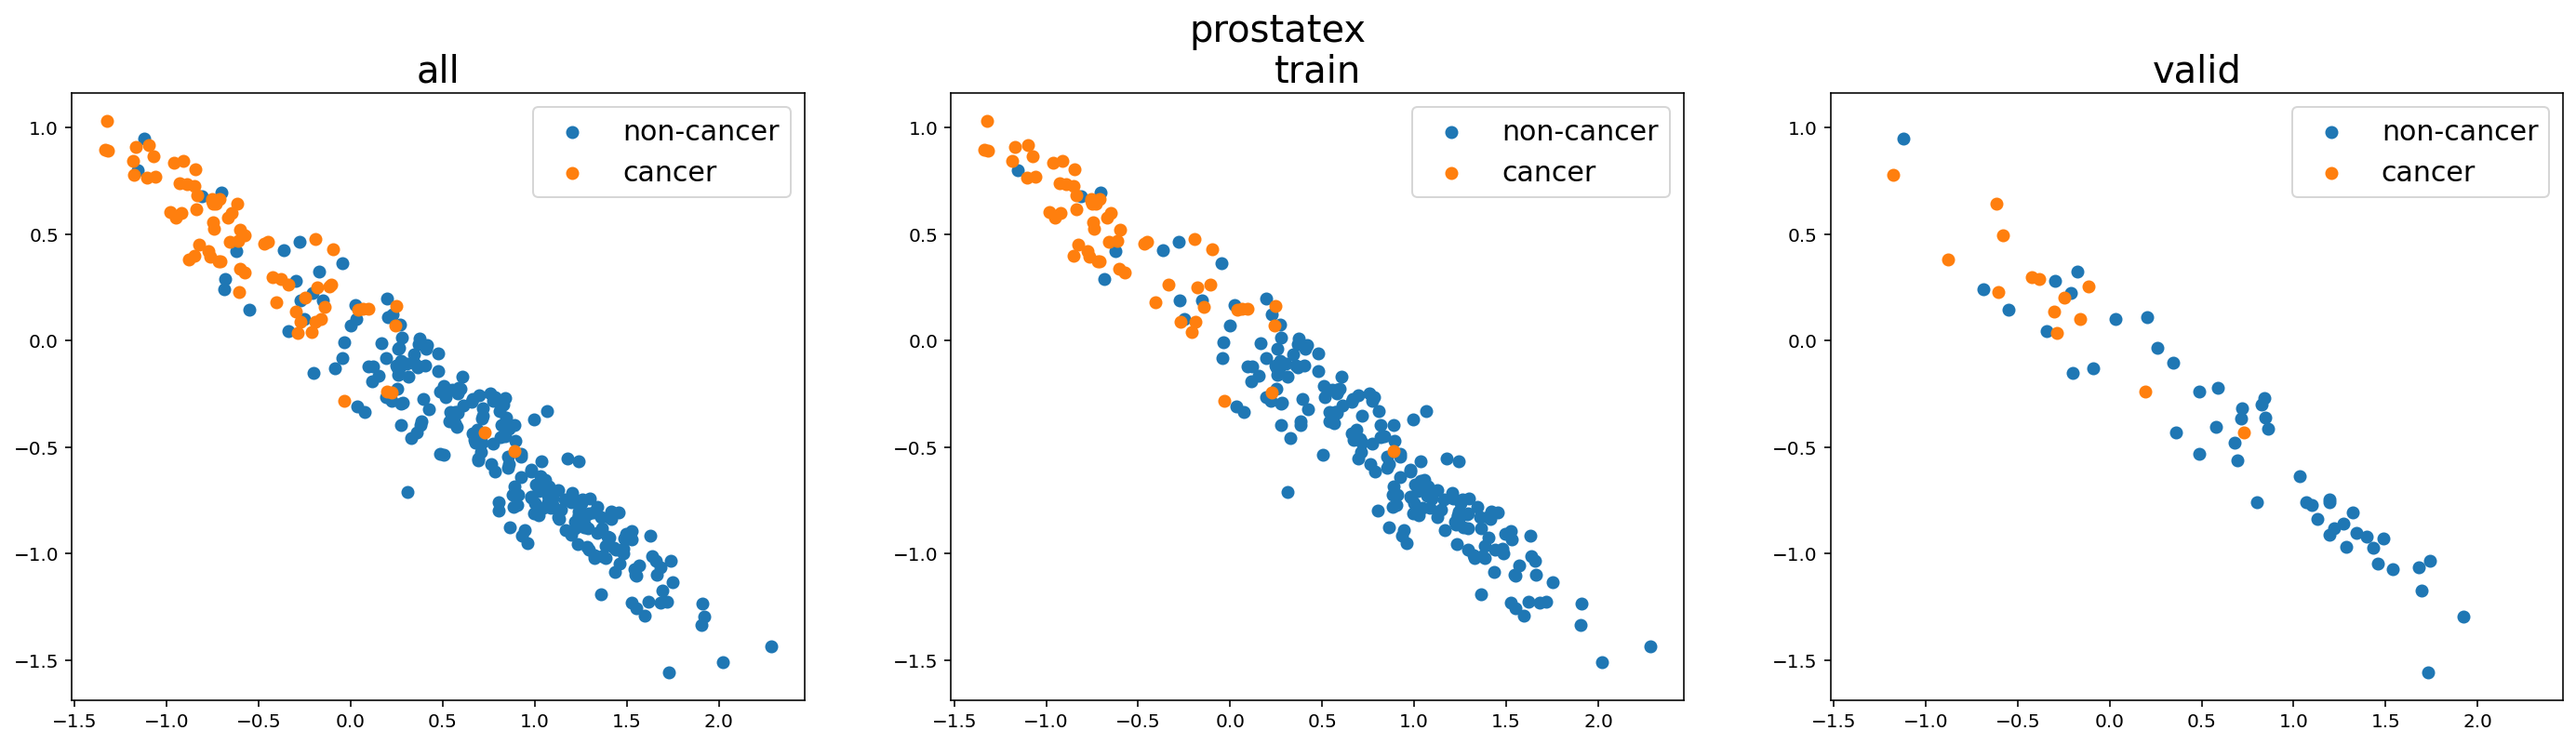

In [ ]:
model, name = 'dwac', 'emb10.merged2'
title = "prostatex"

train_path = '{}_train_{}.pkl'.format(model, name)
f_train_dwac, y_train_dwac, x_train_dwac = pickle.load(open(train_path, "rb"))
valid_path = '{}_valid_{}.pkl'.format(model, name)
f_valid_dwac, y_valid_dwac, x_valid_dwac = pickle.load(open(valid_path, "rb"))
vis_data(x_train_dwac, y_train_dwac, x_valid_dwac, y_valid_dwac, title, save=False)
x_train_dwac.shape

(256, 2)

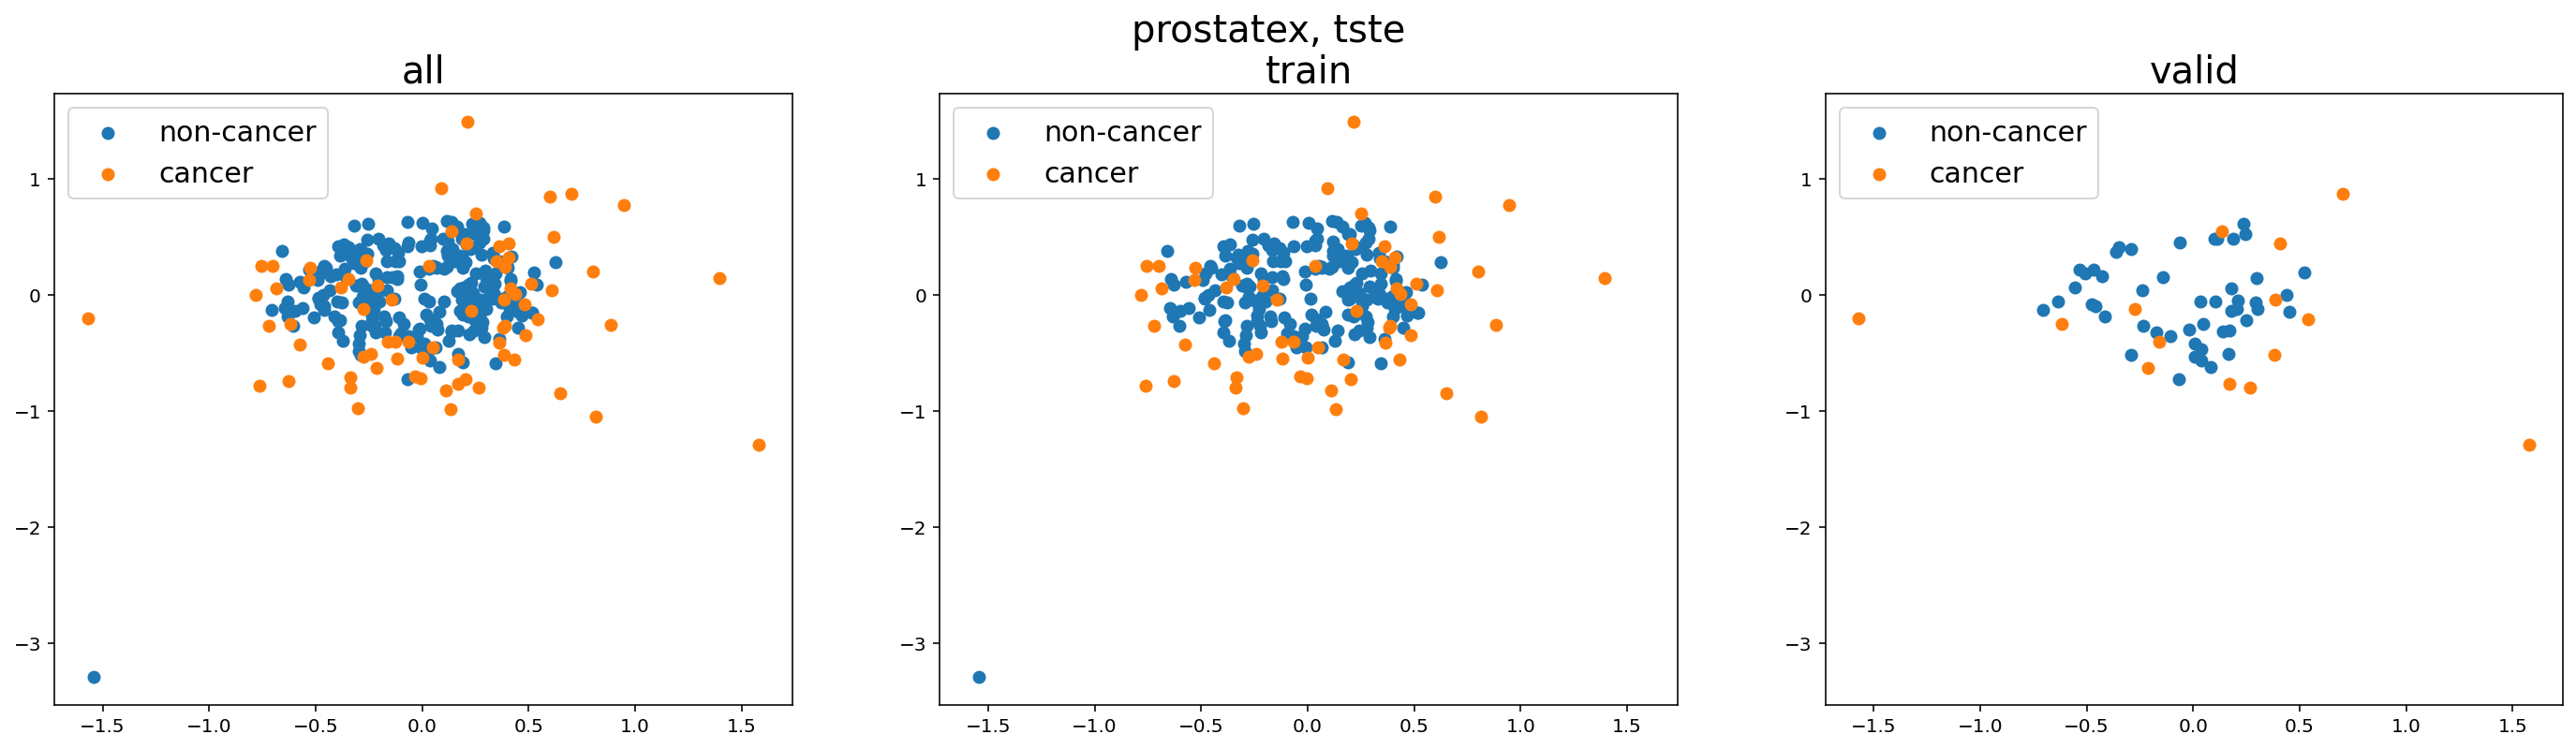

In [ ]:
title = "prostatex, tste"
model, name = "tste", "px"

train_path = '{}_train_{}.pkl'.format(model, name)
f_train_tste, y_train_tste, x_train_tste = pickle.load(open(train_path, "rb"))
valid_path = '{}_valid_{}.pkl'.format(model, name)
f_valid_tste, y_valid_tste, x_valid_tste = pickle.load(open(valid_path, "rb"))
vis_data(x_train_tste, y_train_tste, x_valid_tste, y_valid_tste, title, save=False)
x_train_tste.shape

(319, 2)

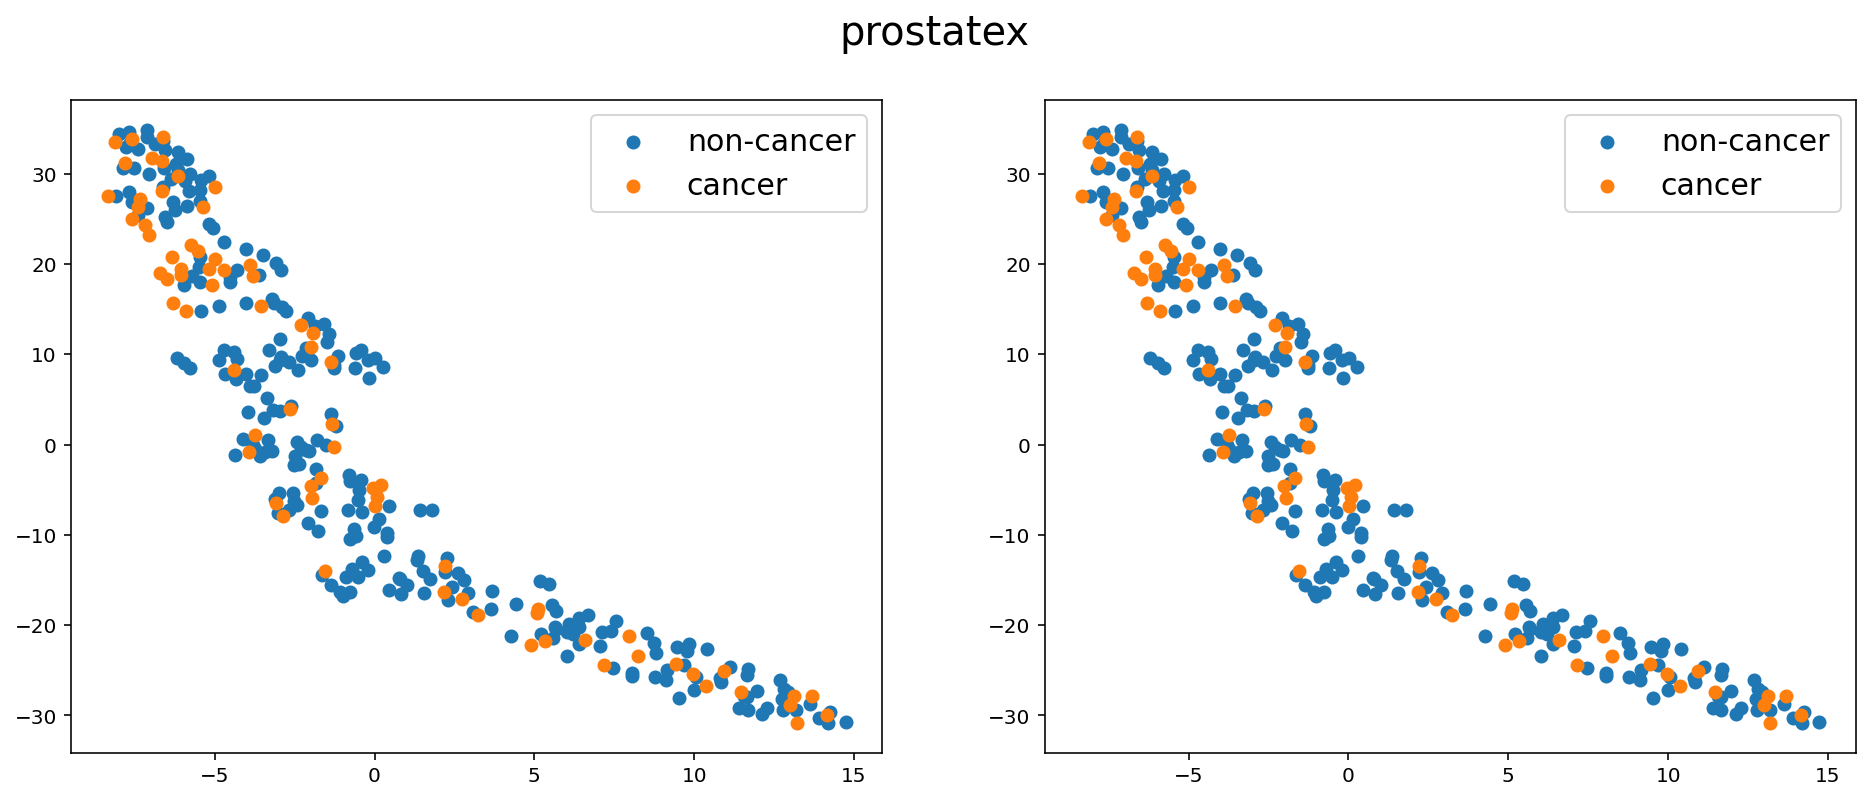

In [ ]:
x_snack = np.load("embeds/snack_dwac+lpips.npy")
y_snack_path = "embeds/tste_all_px.pkl"
y_snack = pickle.load(open(y_snack_path, "rb"))[1]
assert (x_snack.shape[0]==y_snack.shape[0])
vis_data_all(x_snack, y_snack, title, save=False)
x_snack.shape

## knn/svm on tste embeds

In [ ]:
L = 0.5
Kernel = 'Gaussian'
Gamma = 0.5

k_range = [1, 3]
m_range = list(range(3, 11))

In [ ]:
dataset = 'prostatex'
model = 'dwac'
name = 'emb10.merged2'
train_path = '{}_train_{}.pkl'.format(model, name)
valid_path = '{}_valid_{}.pkl'.format(model, name)
f_train, y_train, X_train = pickle.load(open(train_path, "rb"))
f_valid, y_valid, X_valid = pickle.load(open(valid_path, "rb"))
data = X_train, y_train, X_valid, y_valid

In [ ]:
dwac_f_scores_knn, dwac_f_score_svm = utils.get_full_score(data, k_range)
dwac_r_means_knn, dwac_r_confs_knn, dwac_r_means_svm, dwac_r_confs_svm = utils.get_random_score(data, k_range, m_range)
dwac_p_scores_knn, dwac_p_scores_svm = utils.get_protodash_score(data, k_range, m_range)

Text(0.5, 0.98, 'prostatex, dwac.emb10.merged2, AUC, KNN weights uniform')

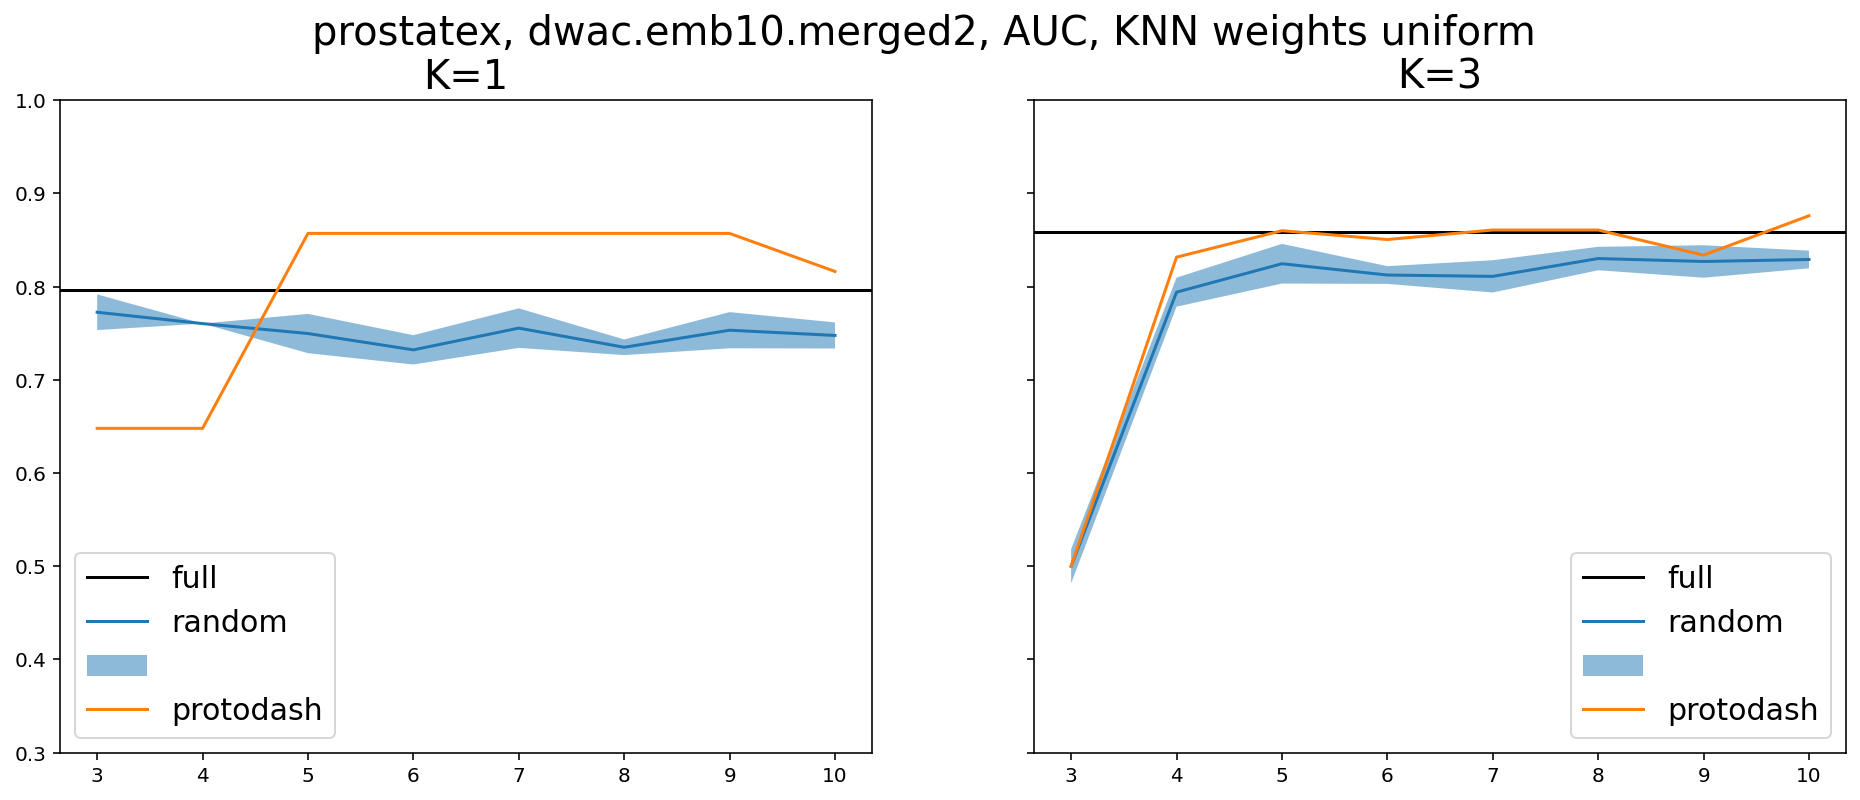

In [ ]:
fig, ax = plt.subplots(1, len(k_range), figsize=(16, 6), sharey=True)
for k in range(len(k_range)):
    ax[k].axhline(dwac_f_scores_knn[k], c='black')
    ax[k].plot(m_range, dwac_r_means_knn[k])
    ax[k].fill_between(m_range, dwac_r_means_knn[k] + dwac_r_confs_knn[k] / 2, dwac_r_means_knn[k] - dwac_r_confs_knn[k] / 2, alpha=0.5)
    ax[k].plot(m_range, dwac_p_scores_knn[k])
    ax[k].set_ylim(0.3, 1)
    ax[k].set_xticks(m_range)
    ax[k].set_title('K={}'.format(k_range[k]))
    ax[k].legend(['full', 'random', '', 'protodash', 'pdash_e', 'proto_g', 'protoclass', 'lpips'])
fig.suptitle('{}, {}.{}, AUC, KNN weights '.format(dataset, model, name) + "uniform")

In [ ]:
model= "tste"
train_path = '{}_train_px.pkl'.format(model)
valid_path = '{}_valid_px.pkl'.format(model)
f_train_tste, y_train_tste, x_train_tste = pickle.load(open(train_path, "rb"))
f_valid_tste, y_valid_tste, x_valid_tste = pickle.load(open(valid_path, "rb"))

data = x_train_tste, y_train_tste, x_valid_tste, y_valid_tste

In [ ]:
tste_f_scores_knn, tste_f_score_svm = utils.get_full_score(data, k_range)
tste_r_means_knn, tste_r_confs_knn, tste_r_means_svm, tste_r_confs_svm = utils.get_random_score(data, k_range, m_range)
tste_p_scores_knn, tste_p_scores_svm = utils.get_protodash_score(data, k_range, m_range)

Text(0.5, 0.98, 'prostatex, tste, AUC, KNN weights uniform')

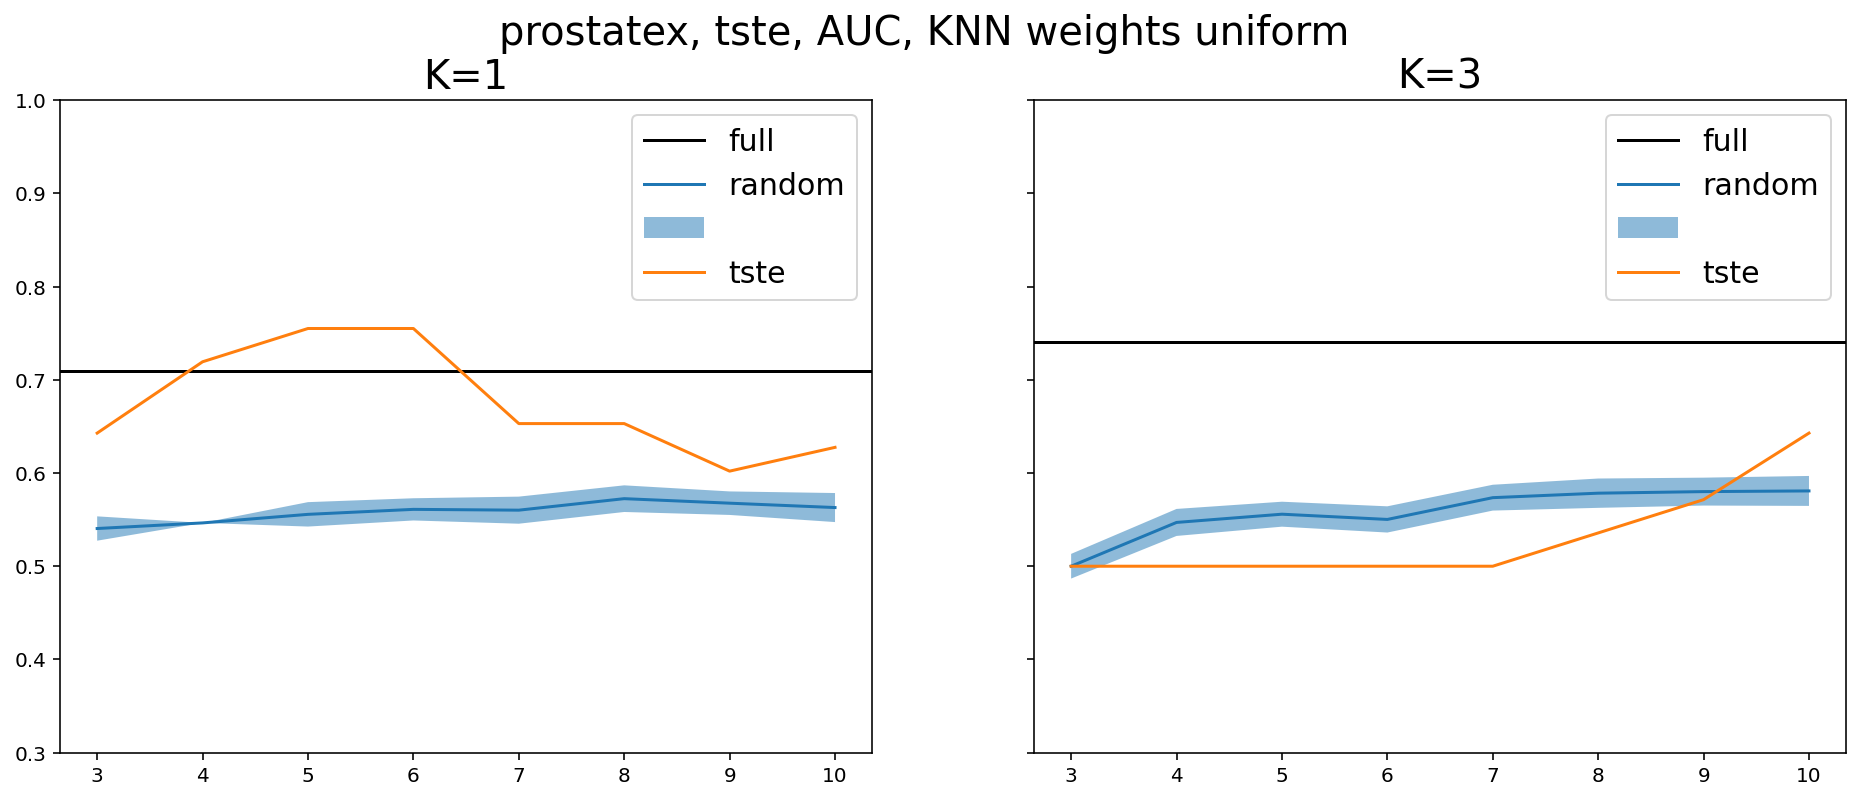

In [ ]:
fig, ax = plt.subplots(1, len(k_range), figsize=(16, 6), sharey=True)
for k in range(len(k_range)):
    ax[k].axhline(tste_f_scores_knn[k], c='black')
    ax[k].plot(m_range, tste_r_means_knn[k])
    ax[k].fill_between(m_range, tste_r_means_knn[k] + tste_r_confs_knn[k] / 2, tste_r_means_knn[k] - tste_r_confs_knn[k] / 2, alpha=0.5)
    ax[k].plot(m_range, tste_p_scores_knn[k])
    ax[k].set_ylim(0.3, 1)
    ax[k].set_xticks(m_range)
    ax[k].set_title('K={}'.format(k_range[k]))
    ax[k].legend(['full', 'random', "", 'tste', 'pdash_e', 'proto_g', 'protoclass', 'lpips'])
fig.suptitle('{}, {}, AUC, KNN weights '.format(dataset, model) + "uniform")

Text(0.5, 0.98, 'prostatex, dwac vs tste, AUC, KNN weights uniform')

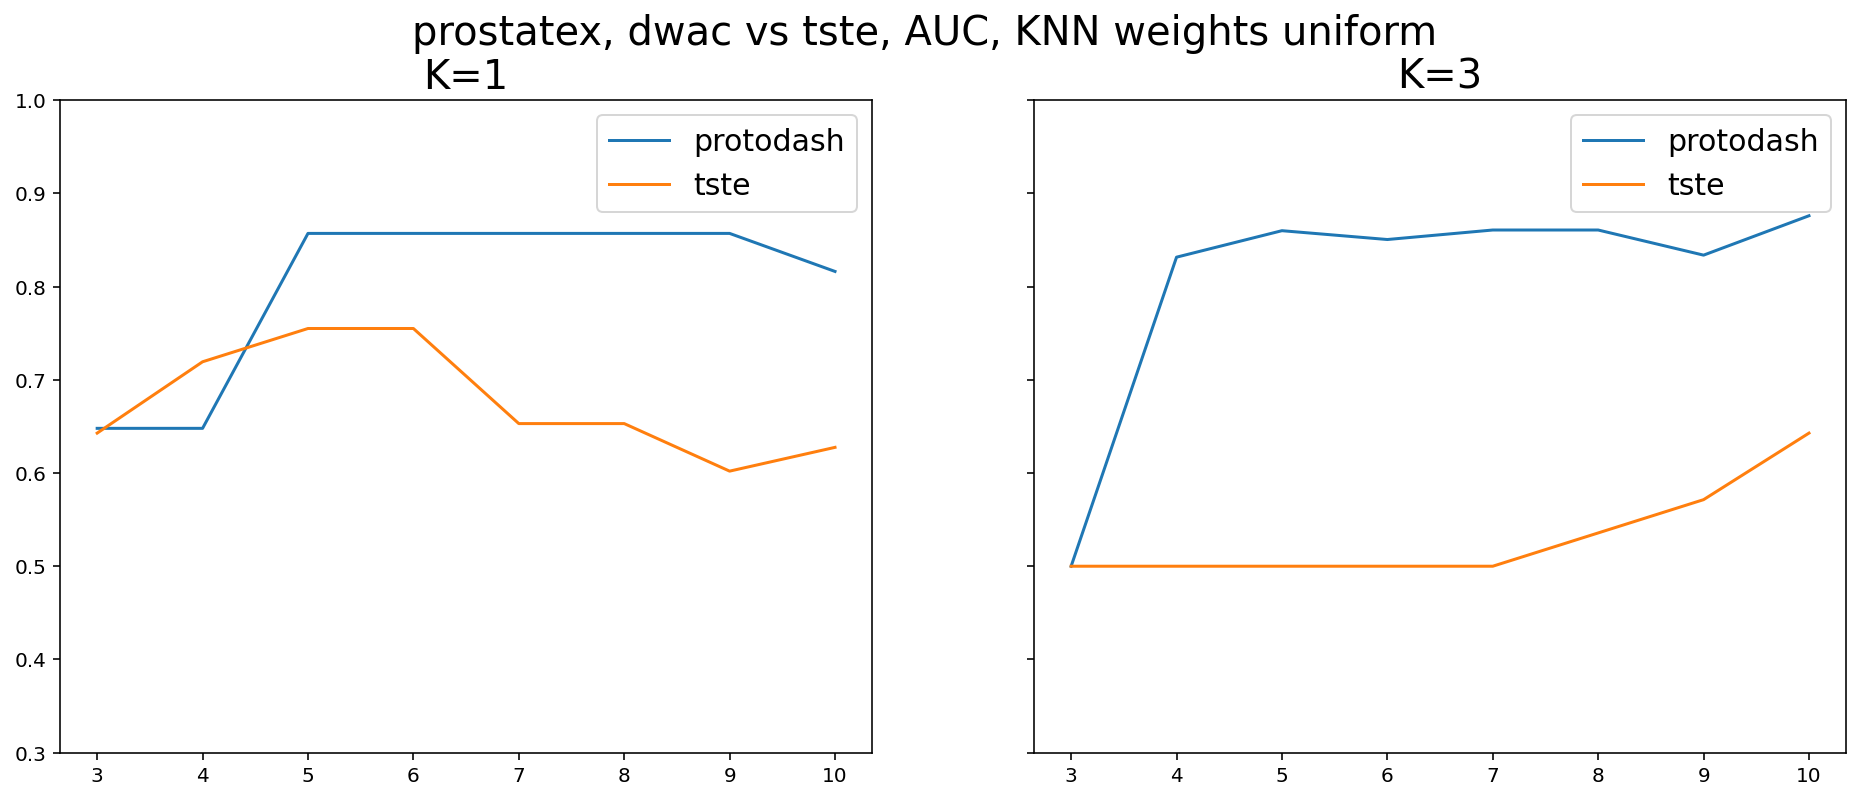

In [ ]:
fig, ax = plt.subplots(1, len(k_range), figsize=(16, 6), sharey=True)
for k in range(len(k_range)):
    ax[k].plot(m_range, dwac_p_scores_knn[k])
    ax[k].plot(m_range, tste_p_scores_knn[k])
    ax[k].set_ylim(0.3, 1)
    ax[k].set_xticks(m_range)
    ax[k].set_title('K={}'.format(k_range[k]))
    ax[k].legend(['protodash', 'tste'])
fig.suptitle('{}, dwac vs tste, AUC, KNN weights uniform'.format(dataset))